In [1]:
# Outside packages
import os
import sys
import torch
import numpy as np
from tqdm import tqdm
import albumentations as A
from matplotlib import pyplot as plt
from tensorboardX import SummaryWriter


# Custom classes
sys.path.append('./modules')
from model_tools import Hourglass
from temp_dataset_tools import make_dataset
from loss_tools import loss_function_wrapper
from data_tools import MapDataset, transform_data, get_stats

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
parent_dir = './temp_ds/ds_17/'
model = Hourglass(depth=1).to(device)
state_dict_path = "./active/2023.12.24 I shouldn't be working right now/model_saves/gcel, small, label=2 epoch=15000.pth"

_ = model.load_state_dict(torch.load(state_dict_path))

In [3]:
def temp_gen(parent_dir, model):
    for fname in sorted(os.listdir(os.path.join(parent_dir, 'images')))[::-1]:
        print(os.path.join(parent_dir, 'images', fname))
        if fname[-4:] != '.npy':
            continue
        image = np.load(os.path.join(parent_dir, 'images', fname))
        mask = np.load(os.path.join(parent_dir, 'masks', fname))
        pred = model(torch.Tensor(np.expand_dims(image, [0, 1])).to(device))
        pred = pred.detach().cpu().numpy().squeeze()
        plt.figure(figsize=[20, 10])
        plt.subplot(1, 2, 1)
        plt.imshow(pred, cmap='jet')
        plt.subplot(1, 2, 2)
        plt.imshow(mask, cmap='jet')
        yield

tg = temp_gen(parent_dir, model)

./temp_ds/ds_17/images/annotations.json
./temp_ds/ds_17/images/20190822_movie_01_SampleOldA1_120kV_81x2048x2048_30sec_Aligned patch_080.jpg.npy


/home/linok/miniforge3/envs/merons/lib/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1699542476443/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


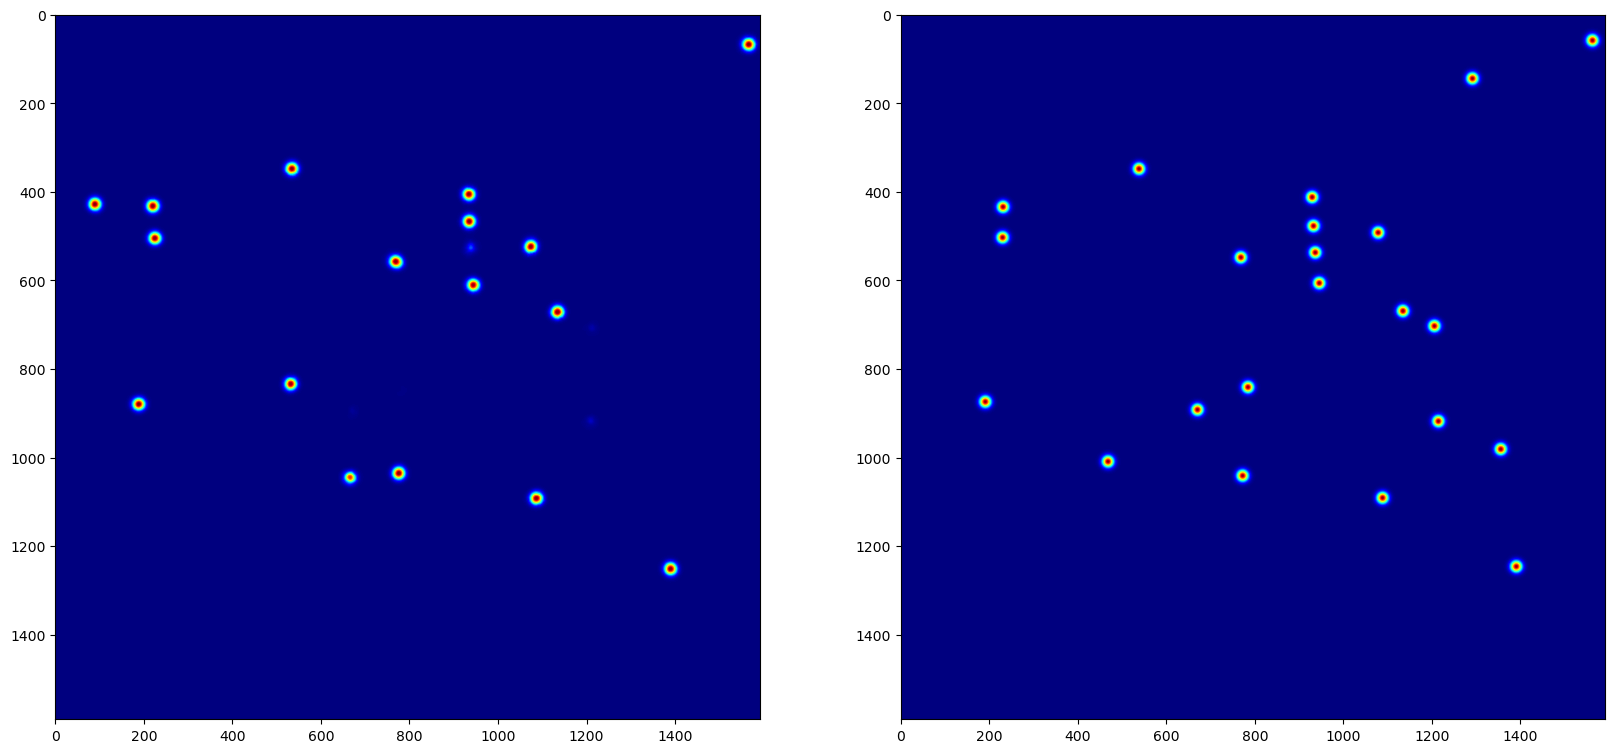

In [4]:
next(tg)

precision:	0.824
recall:		0.636
f1:		0.718


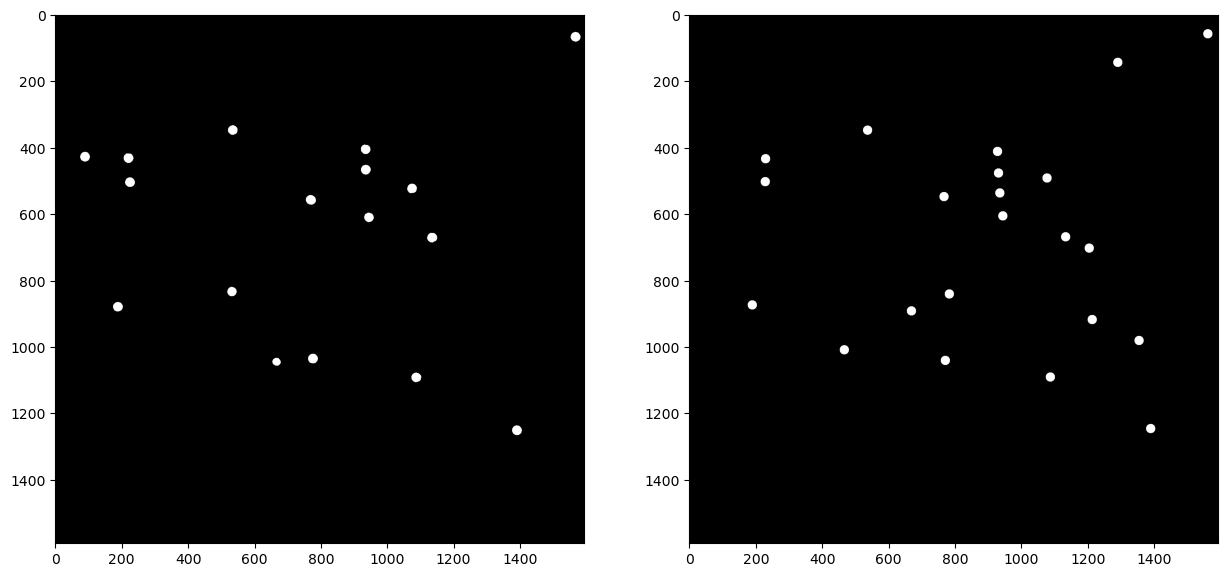

In [5]:
img = '20190822_movie_01_SampleOldA1_120kV_81x2048x2048_30sec_Aligned patch_080.jpg.npy'
t = torch.Tensor(np.expand_dims(np.load(parent_dir + '/images/' + img) / 255, [0, 1])).to(device)
t1 = model(t).detach().cpu().numpy().squeeze()
t2 = np.load(parent_dir + '/masks/' + img)
s = get_stats(t1, t2)
print("precision:\t{:.3f}\nrecall:\t\t{:.3f}\nf1:\t\t{:.3f}".format(s[0], s[1], s[2]))
plt.figure(figsize=[15, 7.5])
plt.subplot(1, 2, 1)
plt.imshow(s[-1][0], cmap='Greys_r')
plt.subplot(1, 2, 2)
plt.imshow(s[-1][1], cmap='Greys_r')
_ = plt.show()